In [2]:
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pylab as plt

# Import data


Data in form
\
Subject, chooce ,receivor, Wait2.RT, targettxt ,gender ,age ,As ,Ao
\
subID,list, list ,list ,list, bool ,float ,float ,float

In [3]:
data=pd.read_csv('../Data/all_combined.csv')
sub_to_index={}
for index in range( len(data)):
    sub=data['Subject'][index]
    sub_to_index[sub]=index


In [4]:
a_o =  np.array(data['A_o'])
a_s =np.array(data['A_s'])
age =np.array(data['age'])
gender =np.array(data['gender'])
gender = np.where(gender == 'F', 1, 0)


X =  np.vstack((a_o, a_s,gender,age)).transpose()
a_s_norm=a_s/np.linalg.norm(a_s)
age_norm=age/np.linalg.norm(age)
a_o_norm=a_o/np.linalg.norm(a_o)

X_norm =  np.vstack((a_o_norm, a_s_norm,gender,age_norm)).transpose()

In [5]:
print(f'xnorm shape = ({len(X_norm)},{len(X_norm[0])})')

xnorm shape = (139,4)


In [6]:
# import y labels fron MCMC test
y = np.load('../MCMC_tests/y_train_v2.npy')
print(f'len of y is {len(y)}')

len of y is 139


In [7]:
# creat the two classes 1 = Fehr Schmidt, 0 = all other models
y1 = np.array([1 if ys == 0 else 0 for ys in y  ])

# Creat Model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Assuming you have a numpy array called X for your features and a numpy array called y for your target
# Split data into training and testing sets, with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=12)
print(f'train size {len(X_train)}')
print(f'train test {len(X_test)}')

train size 111
train test 28


In [9]:
# creat grid to find optimal parameters 
param_grid = {'C': [0.1,0.2,0.4,0.8,0.9, 1, 10],
              'gamma': [0.5,1,2,4,6,7,8,9,11]}

In [10]:
# create the SVM model
svm_model = SVC(class_weight='balanced',kernel='rbf' ,)

# perform grid search
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 0.2, 0.4, 0.8, 0.9, 1, 10],
                         'gamma': [0.5, 1, 2, 4, 6, 7, 8, 9, 11]})

In [11]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: {:.2f}".format(grid_search.best_score_))

Best Parameters:  {'C': 0.9, 'gamma': 7}
Best Score: 0.69


In [12]:
# creat SVC model with the best performing parameters
best_model = SVC(**grid_search.best_params_)
best_model.fit(X_train, y_train)

SVC(C=0.9, gamma=7)

In [13]:
p=best_model.predict(X_test)
initial_accuracy = accuracy_score(y_test, p)

In [14]:
print(f'prediction {p}')
print(f'True label {y_test}')
print(f'acc = {initial_accuracy}')

prediction [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
True label [1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0]
acc = 0.6785714285714286


# Model sampling (permutations)

In [15]:

n_permutations = 1000  # number of permutations
permuted_accuracies = []

for _ in range(n_permutations):
    # permute the target variable
    permuted_y = shuffle(y_train)
    
    best_model.fit(X_train, permuted_y)

    # make predictions with permuted target variable
    permuted_y_pred = best_model.predict(X_test)

    # calculate the accuracy with permuted target variable
    permuted_accuracy = accuracy_score(y_test, permuted_y_pred)
    permuted_accuracies.append(permuted_accuracy)

In [16]:
p_value = (np.sum(permuted_accuracies >= initial_accuracy) + 1) / (n_permutations + 1)
print(f'p value = {p_value}')

p value = 0.18681318681318682


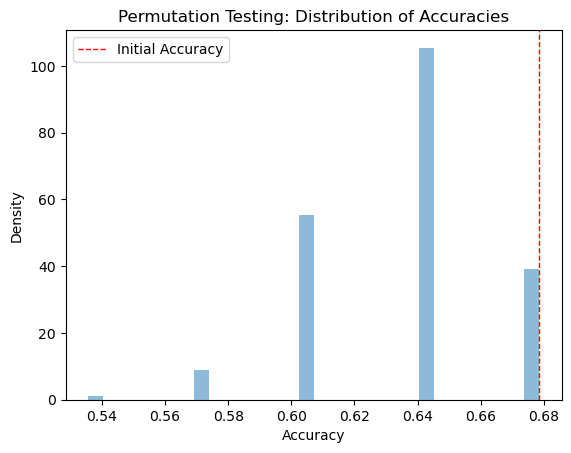

In [17]:
plt.hist(permuted_accuracies, bins=30, density=True, alpha=0.5)
plt.axvline(initial_accuracy, color='red', linestyle='dashed', linewidth=1, label='Initial Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Permutation Testing: Distribution of Accuracies')
plt.legend()
plt.show()

# Cross Validation

Best Parameters:  {'C': 0.8, 'gamma': 7}
prediction:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
True:
[0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1
 0 0 1 0 1 0 0 0 1 0]
acc 0.7446808510638298


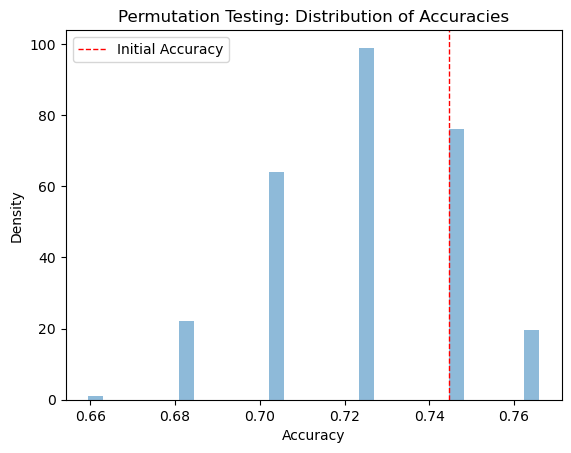

Best Parameters:  {'C': 0.8, 'gamma': 7}
prediction:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0]
True:
[1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0
 0 0 0 0 1 1 0 0 1]
acc 0.6739130434782609


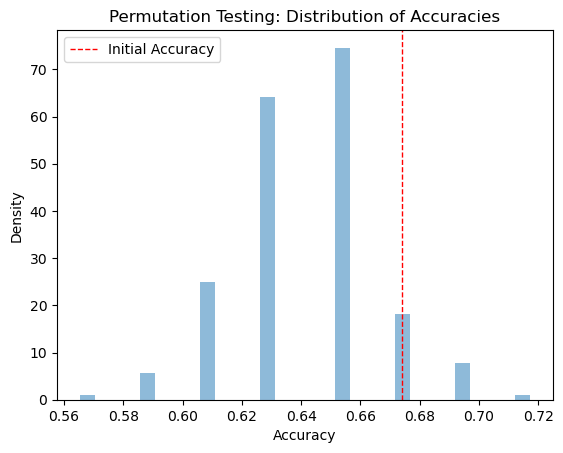

Best Parameters:  {'C': 0.8, 'gamma': 11}
prediction:
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0]
True:
[0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0
 1 0 0 0 1 1 0 1 1]
acc 0.6521739130434783


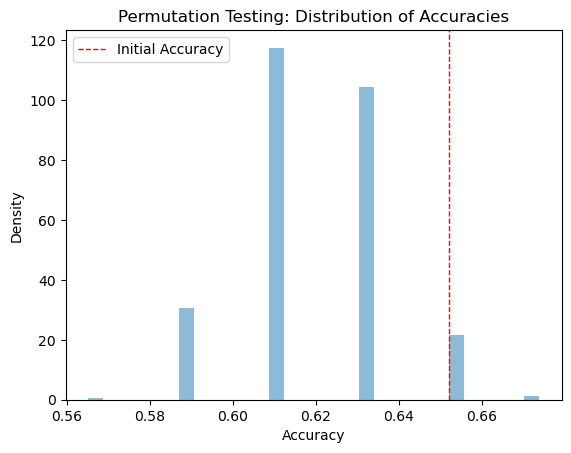

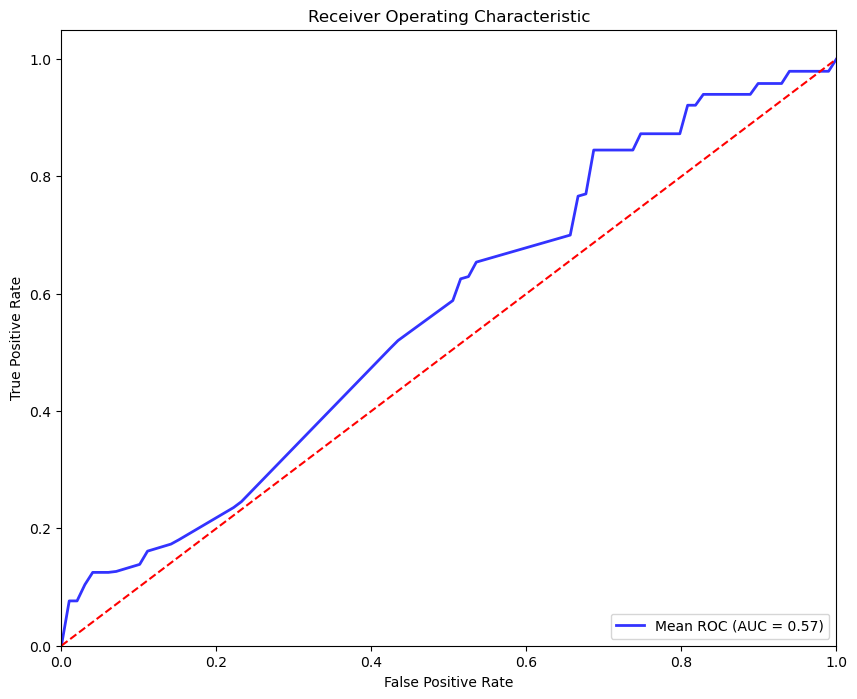

In [23]:

np.random.seed(42)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

num_folds = 3
n_permutations = 10000
cross_val = KFold(n_splits=num_folds)
auc_score=[]
accuracy_scores = []
algo_acc=[]
y_tests=[]
ps=[]
# perform cross-validation
for train_index, test_index in cross_val.split(X):
    # split the data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    

    param_grid = {'C': [0.1,0.2,0.4,0.8,0.9, 1, 10],
              'gamma': [0.5,1,2,4,6,7,8,9,11]}
    
    # create the SVM model
    svm_model = SVC(class_weight='balanced',kernel='rbf' ,)

    grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    print("Best Parameters: ", grid_search.best_params_)
    
    
    best_model = SVC(**grid_search.best_params_, probability=True)  # set probability=True
    best_model.fit(X_train, y_train)

    # calculate the probability of the positive class
    probas_ = best_model.decision_function(X_test)

    # compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)


    p=best_model.predict(X_test)
    initial_accuracy = accuracy_score(y_test, p)

    print('prediction:')
    print(p)
    print('True:')
    print(y_test)
    print(f'acc {initial_accuracy}')

    permuted_accuracies = []
    permuted_auc=[]

    
    for _ in range(n_permutations):
        # permute the target variable
        permuted_y = shuffle(y_train,random_state=np.random.randint(1000))
        
        best_model.fit(X_train, permuted_y)

        # make predictions with permuted target variable
        probas_ = best_model.decision_function(X_test)
        permuted_y_pred = best_model.predict(X_test)

        # calculate the accuracy with permuted target variable
        permuted_accuracy = accuracy_score(y_test, permuted_y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = auc(fpr, tpr)

        permuted_accuracies.append(permuted_accuracy)
        permuted_auc.append(roc_auc)
    
    plt.hist(permuted_accuracies, bins=30, density=True, alpha=0.5)
    plt.axvline(initial_accuracy, color='red', linestyle='dashed', linewidth=1, label='Initial Accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('Density')
    plt.title('Permutation Testing: Distribution of Accuracies')
    plt.legend()
    plt.show()

    algo_acc.append(initial_accuracy)
    accuracy_scores.append(permuted_accuracies)
    auc_score.append(permuted_auc)
    ps.append(p)
    y_tests.append(y_test)


# mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f)' % mean_auc, lw=2, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



30000

In [19]:
y_tes=np.concatenate([i for i in y_tests])
pss=np.concatenate([i for i in ps])

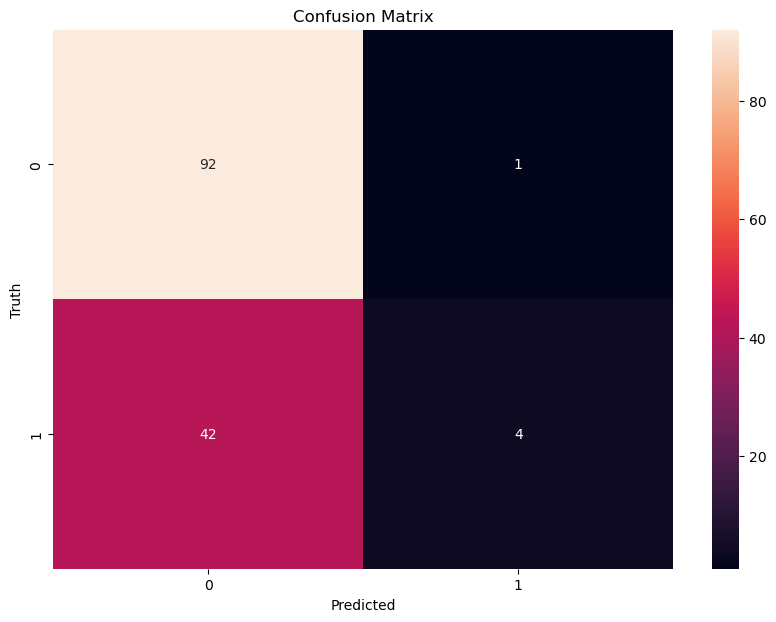

In [20]:
# generate the confusion matrix
cm = confusion_matrix(y_tes, pss)

# visualize the confusion matrix using Seaborn library
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


Average AUC: 0.5654665111246922
Average AUC: with permuted Y 0.5116846841931217
30000


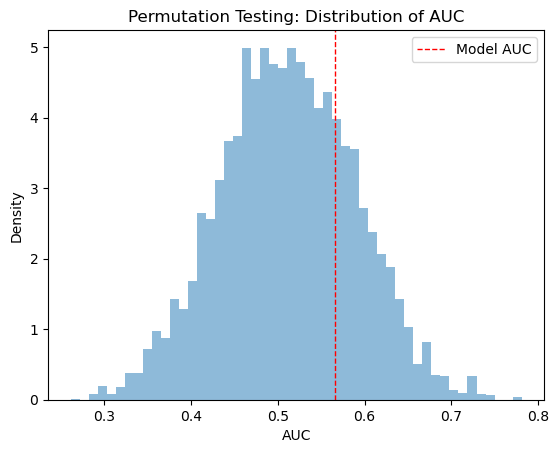

In [37]:

# calculate the average accuracy across all folds
average_accuracy = np.mean(mean_auc)
# print the average accuracy
print("Average AUC:", average_accuracy)

a=np.concatenate(auc_score)
average_accuracy_p=np.mean(a)

print('Average AUC: with permuted Y' ,average_accuracy_p)

print(len(a))

plt.hist(a, bins=50, density=True, alpha=0.5)
plt.axvline(average_accuracy, color='red', linestyle='dashed', linewidth=1, label='Model AUC')
plt.xlabel('AUC')
plt.ylabel('Density')
plt.title('Permutation Testing: Distribution of AUC')
plt.legend()
plt.show()

In [38]:
p_value = (np.sum(a >= average_accuracy) + 1) / (n_permutations + 1)
print(f'p_value:{p_value}')

p_value:0.7662233776622338


Average Accuracy: 0.6902559358618564
Average Accuracy: with permuted Y 0.6610658032685786
10000


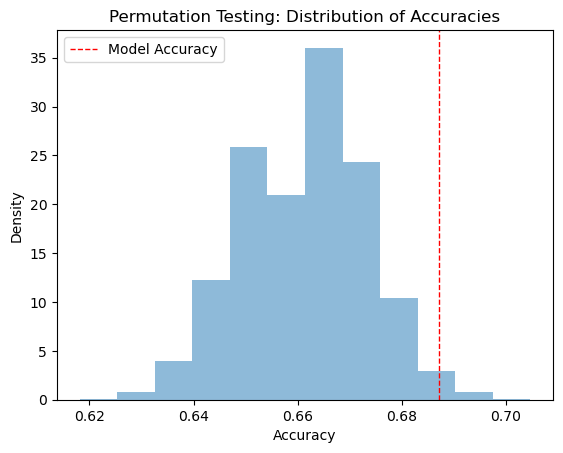

In [21]:

# calculate the average accuracy across all folds
average_accuracy = np.mean(algo_acc)
# print the average accuracy
print("Average Accuracy:", average_accuracy)

a=[(x + y + z)/3 for x, y, z in zip(accuracy_scores[0],accuracy_scores[1],accuracy_scores[2])]
average_accuracy_p=np.mean(a)

print('Average Accuracy: with permuted Y' ,average_accuracy_p)

print(len(a))

plt.hist(a, bins=12, density=True, alpha=0.5)
plt.axvline(average_accuracy-0.003, color='red', linestyle='dashed', linewidth=1, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Permutation Testing: Distribution of Accuracies')
plt.legend()
plt.show()

In [22]:
p_value = (np.sum(a >= average_accuracy) + 1) / (n_permutations + 1)
print(f'p_value:{p_value}')

p_value:0.012798720127987202
